# Camera Calibration

Cameras introduce distortions into our data, these arise for various reasons such as the SSD, focal length, lens distortions, etc. Perhaps the most obvious is when using a fish-eye lens, this allows for a wider area to be captured however introduces large distortions near the image edges. 

Camera calibration is the process of determining the internal camera geometric and optical characteristics and/or the orientation of the camera frame relative to a certain world coordinate system. Physical camera parameters are commonly divided into extrinsic and intrinsic parameters. 

## Extrinsic Parameters
Extrinsic parameters are needed to transform object coordinates to a camera centered coordinate frame. To simplify this problem we use the camera pinhole model as shown in figure 1:

<img src="Camera_Calibration/pinhole.png" style="width:40%"/>

This is based on the principle of collinearity, where each point in the object space (X,Y,Z) is projected by a straight line through the projection center into the image plane (x,y,z). so the problem can be simplified to a simple transformation:

<img src="Camera_Calibration/transformation.png" style="width:40%"/>

Where matrix m carries out the translation and rotation whcih translate the coordinates of a 3D point to a coordinate system

## Intrinsic Parameters
These are parameters specific to the camera and map the coordinates from the image-plane/SSD (x,y,z) to the digital image (pixel coordinate axis with origin commonly in the upper left corner of the iamge array). Parameters often included are the focal length $(f_x, f_y)$ ,optical centers $(c_x, c_y)$, etc. The values are often stored in what we call the camera matrix:

<img src="Camera_Calibration/matrix.png" style="width:40%"/>

These are specific to the camera, so can be stored for future use.


## Extended model
The pinhole model is only an approximation of the real camera projection! It is useful to establish simple mathematical formulations, however is not valid when high accuracy is required! Often the pinhole model is extended with some corrections, 2 common distortion corrections are: 

1. radial -> straight lines will appear curved due to image points being displaced radially. More pronounced near the image edges. this distortion is solved as follows in our example below:
$$x_{corrected} = x (1+k_1 r^2 +k_2 r^4 + k_3 r^6  )$$
$$y_{corrected} = y (1+k_1 r^2 +k_2 r^4 + k_3 r^6  )$$
2. tangential -> occurs because the lense is not algined perfectly parallel to the image plane. Visualised as some areas in the image looking nearer than expected. This distortion is solved as follows in our example below:
$$x_{corrected} = x + (2p_1xy+p_2(r^2+2x^2))$$
$$y_{corrected} = y + (p_1(r^2+2y^2)+2p_2xy)$$

So we are looking for the followig distortion coefficients:
$$ (k_1, k_2, p_1, p_2, k_3)$$

See image transformations notebook for further understanding of how these equations function

## Solving
We can link the image coordinates and real world coordinates for a few points and hence we can solve for the translation matrix , with an empirical inverse model, to map between real world and image coordinates. 

Typically a checkerboard tends to be used to take images for easy point detection, from this the calibration matrixes are calculated. Then these matrixes can be stored and used to undistort other images. An example of how this process works is demonstrated below, images can be obtained from [here](https://github.com/DavidWangWood/Camera-Calibration-Python).

In [20]:
# import required libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [21]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32) 
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('Camera_Calibration/GO*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners, set grid pattern that is looked for (8,6)
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If corners found, add object points, image points
    if ret == True: 
        objpoints.append(objp)
        
        imgpoints.append(corners)
       
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img) #save image
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

Text(0.5, 1.0, 'Undistorted Image')

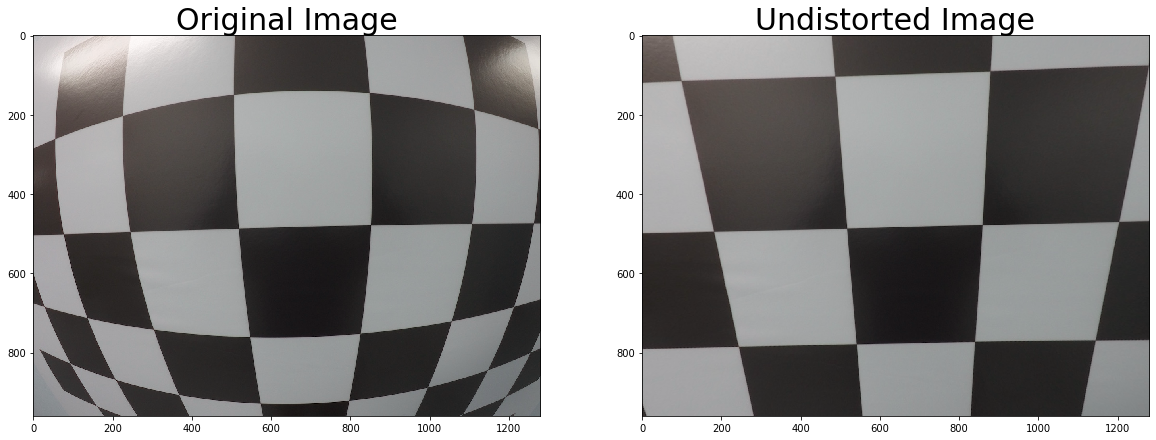

In [22]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('Camera_Calibration/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
#returns camerae matrix, distortion coefficeints, rotation and translation vectors

#undistort image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('Camera_Calibration/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "Camera_Calibration/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Now you can store the camera matrix and distortion coefficients using write functions in Numpy (np.savez, np.savetxt etc) for future uses.

## Errors
Re-projection error gives a good estimation of just how exact the found parameters are. This should be as close to zero as possible.

In [23]:
tot_error=0
for i in range(len(objpoints)):
    # transform object point to image point 
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    #calculate absolute norm between result of transformation and the corner finding algorithm
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error
#display the average error for all calibration images
print ("total error: ", tot_error/len(objpoints))

total error:  0.07734682307626488


to reduce errors a few measures can be taken:
- make sure reflections on chessboard are minimized
- use an checkerboard that cannot bend (print board and stick on a board)
- eliminate images with the largest calculated error as long as more than 10 images are remaining
Ideal procedure to take pictures for calibration can be found [here](https://www.theeminentcodfish.com/gopro-calibration/).

**NOTE**: If you change between wide angle/linear/super-wide or video/photo or resolution or any other function which may change image dimensions in px on the camera, you will require a new calibration matrix! Hence use the settings you are planning on using in your experiment from the start.

example we obtained in the lab without cropping:

<img src="Camera_Calibration/picture1.png" style="width:40%"/>
<img src="Camera_Calibration/picture2.png" style="width:40%"/>

# references 
- OpenCV functions: <br /> Mordvintsev, A. and K, A., 2017. Opencv-Python Tutorials Documentation. 1st ed. [ebook] pp.207 - 214. Available at: <https://buildmedia.readthedocs.org/media/pdf/opencv-python-tutroals/latest/opencv-python-tutroals.pdf> [Accessed 2 July 2020].
- Code and checkerboard images obtained from: <br /> https://github.com/DavidWangWood/Camera-Calibration-Python
- Paper with more advanced calibration technique: <br /> Heikkilä, J. and Silvén, O., n.d. A Four-step Camera Calibration Procedure with Implicit Image Correction. [online] Available at: <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.94.7536&rep=rep1&type=pdf> [Accessed 2 July 2020].
- pinhole image: <br /> Slideplayer.com. 2020. [online] Available at: <https://slideplayer.com/slide/5204330/16/images/1/The+Pinhole+Camera+Model.jpg> [Accessed 2 July 2020].